### Imports

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import csv

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image

import os

from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, CSVLogger
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical

### Uniquement si on travaille sur Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration des données

In [ ]:
drive_path = "/content/drive/MyDrive/TP_cars" # remplacer par "./" si run en local

nom_model = "Incept_100e_v1"

sauv_dir = drive_path+"/"+nom_model+"/"
nom_checkpoint_model = nom_model
nom_save_weight = "weights_"+nom_model

if not os.path.exists(sauv_dir):
    os.makedirs(sauv_dir)

In [ ]:
train_data_dir = drive_path+'/cars_cropped/train'
validation_data_dir = drive_path+'/cars_cropped/test'

img_width, img_height = 224, 224 
channels = 3
num_classes = 196

batch_size = 32 #64?

### Viz rapide d'une image

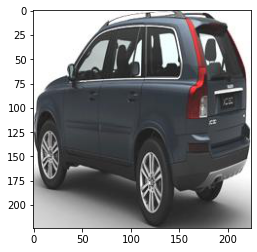

In [ ]:
image = Image.open(train_data_dir+'/Volvo XC90 SUV 2007/00954.jpg')
imgplot = plt.imshow(image)
plt.show()

### Phase de preprocessing

In [ ]:
%%time
train_datagen = ImageDataGenerator(
  rescale=1. / 255,
  shear_range=0.2,
  zoom_range=0.2,
  #fill_mode = 'constant',
  #cval = 1,
  rotation_range = 20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  #horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.
CPU times: user 712 ms, sys: 148 ms, total: 860 ms
Wall time: 40.3 s


In [ ]:
# Nombre de classes
num_classes = len(train_generator.class_indices)

# Encodage des labels de l'échantillon de train
# Ressource : https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

# Encodage des labels de l'échantillon de validation
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

### Visualisation de la data augmentation

In [ ]:
# On prend une image aléatoirement : n02091032-Italian_greyhound/n02091032_55.jpg
img = load_img(train_data_dir+'/Volvo XC90 SUV 2007/00954.jpg')

# Conversion en array
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

# On affiche 9 images pour visualiser la data augmentation
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.show()

### Visualisation des labels (targets)

In [ ]:
# Visualisation des labels
label_maps = {}
for i, v in enumerate(train_generator.class_indices):
    label_maps.update({i:v})
print(f'{len(label_maps)} marques de voiture')

In [ ]:
label_maps

### Création du réseau de neurone

#### Chargement du modèle InceptionV3

In [ ]:
%%time
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
type(InceptionV3)

87916544/87910968 [==============================] - 1s 0us/step
CPU times: user 2.74 s, sys: 377 ms, total: 3.12 s
Wall time: 3.35 s


#### Création d'un modèle avec les couches de l'InceptionV3

In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

# Ajout de la dernière couche avec num_classes (trainable=true)
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               401604    
Total params: 22,204,388
Trainable params: 401,604
Non-trainable params: 21,802,784
_________________________________________________________________


#### Compilation du modèle

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

#### Phase d'entrainement du modèle

Pour améliorer l'apprentissage et les performances du modèle, nous avons ajouté : 
- un `ModelCheckpoint` pour sauvegarder le meilleur modèle à chaque epoch dans un fichier **.h5**
- un `EarlyStopping` pour lutter contre le surapprentissage
- un `CSVLogger` qui permet de logger à chaque epoch les métriques du modèle (accuracy, loss, etc)
- un `ReduceLROnPlateau` pour agir sur le learning rate du modèle à chaque epoch

In [ ]:
checkpoint = ModelCheckpoint(
    sauv_dir+nom_checkpoint_model+'.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= sauv_dir+"training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1, 
    mode='auto'
)

# On enregistre dans un tableau callbacks, qu'on va fournir lors de l'entrainement du modèle
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
%%time
history = model.fit(
    train_generator, 
    epochs = 50,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 1, 
    callbacks = callbacks
)

Epoch 1/50
254/254 [==============================] - ETA: 0s - loss: 5.4814 - accuracy: 0.0094

### Affichage des métriques

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

### Visualisation en plot des courbes d'apprentissage

In [ ]:
# Graph 1 : évolution de l'accuracy selon le nombre d'epoch
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig(sauv_dir+'accuracy.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# Graph 2 : évolution du loss selon le nombre d'epoch
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig(sauv_dir+'loss.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

### Enregistrement des poids du modèle

In [ ]:
model.save_weights(sauv_dir+nom_save_weight+'/ckpt')